# Klasyczny model Isinga
Model Isinga rozpoczął swoje życie jako model ferromagnetyzmu. Ernst Ising wprowadził go na początku lat 20. XX wieku, a od tego czasu stał się fundamentalnym modelem służącym do zrozumienia przejść fazowych i emergentnych właściwości w różnych układach fizycznych. W tym kursie skupimy się na jednym problemie związanym z modelem Isinga: znalezieniu jego stanu podstawowego (tj. stanu o najniższej energii) oraz widma niskich energii. Jak zostanie pokazane później w ramach kursu, model Isinga jest istotny nie tylko w fizyce, ale także wywiera wpływ na takie dziedziny jak finanse, dynamika społeczna oraz optymalizacja w informatyce.


## Definicja

Rozważmy wektor zmiennych binarnych $\bm{s} = (s_1, s_2, \ldots, s_N)$. Zmienne te nazywane są **spinami** i mogą przyjmować jeden z dwóch stanów: w górę (+1) lub w dół (-1), formalnie $s_i = \pm 1$. Spiny są rozmieszczone na pewnym prostym grafie $G$, który opisuje interakcje między nimi. Krawędzie grafu $G$ (oznaczane jako $E(G)$) określają, które spiny oddziałują ze sobą. Siła interakcji (lub *coupling*) między $s_i$ a $s_j$ jest oznaczana jako $J_{ij} \in \mathbb{R}$. Dodatkowo każdy spin poddawany jest działaniu zewnętrznego pola magnetycznego (lub *bias* albo *obciążenie*) $h_i \in \mathbb{R}$. Energia układu opisana jest następującą funckją (**Hamiltonianem**):

$$
H(\bm{s}) = \sum_{(i, j) \in E(G)} J_{ij} s_i s_j + \sum_{i=1}^{N} h_i s_i
$$

Każda realizacja $\bm{s}$ jest nazywana **stanem** albo **konfiguracją**. Trójkę $(G, J, h)$ nazywamy **instancją**.

## Przykład

W tych przykładach zaczniemy od utworzenia przykładowej instancji. Następnie, używając tej instancji policzymy kilka przykładów. 

TODO: Write better

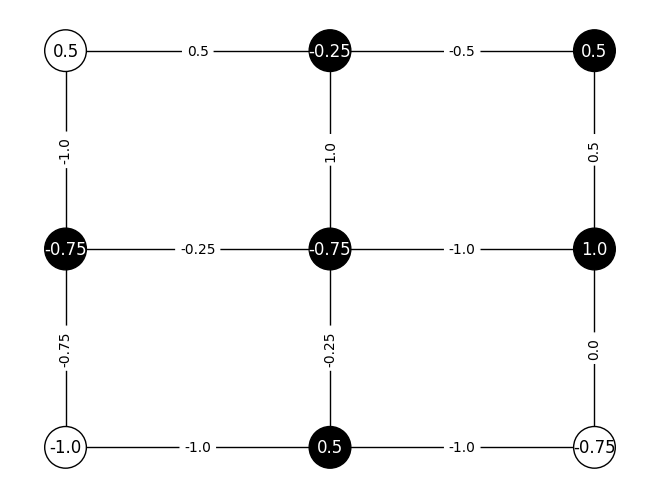

In [2]:
# Instancja  razem z obrazkiem

import random
import networkx as nx
import matplotlib.pyplot as plt

random.seed(7)

# Tworzymy graf
instance = nx.grid_2d_graph(3, 3)

# Nadajemy losowe wartości spinu, h i J
nx.set_node_attributes(instance, {node: random.choice([-1, 1]) for node in instance.nodes}, "spin")
nx.set_node_attributes(instance, {node: random.choice([i / 4 for i in range(-4, 5)]) for node in instance.nodes}, "h")
nx.set_edge_attributes(instance, {edge: random.choice([i / 4 for i in range(-4, 5)]) for edge in instance.edges}, "J")

# Ustalamy kolor wierzchołków w zalezności od wartości spinu, -1 (dół) czarny i +1 (góra) biały
node_colors = ["white" if instance.nodes[node]["spin"] == 1 else "black" for node in instance.nodes]


# Rysujemy instancje której będziemy używać
pos={node: node for node in instance.nodes}
nx.draw(instance, pos, node_color=node_colors,  node_size=900, font_weight='bold')

# rysujemy wierzchołki i pokazujemy wartość h na nich
node_labels = {node: f"{instance.nodes[node]['h']}" for node in instance.nodes}
for node in instance.nodes:
    label = f"{instance.nodes[node]['h']}"
    x, y = pos[node]  
    font_color = "white" if instance.nodes[node]["spin"] == -1 else "black"
    plt.text(x, y, label, fontsize=12, ha='center', va='center', color=font_color)
ax = plt.gca() # to get the current axis
ax.collections[0].set_edgecolor("black") 

# Rysujemy wartości "J" na krawędziach
edge_labels = {(u, v): f"{data['J']}" for u, v, data in instance.edges(data=True)}
nx.draw_networkx_edge_labels(instance, pos, edge_labels=edge_labels)

plt.show()

In [3]:
# Liczenie Energii prosto ze wzoru

spins = {node: instance.nodes[node]["spin"] for node in instance.nodes}
h = {node: instance.nodes[node]["h"] for node in instance.nodes}
J = {(u, v): data['J'] for u, v, data in instance.edges(data=True)}

def navie_energy_calculation(spins, J, h, instance):
    # Liczymy w dwóch pętlach
    energy_naive = 0

    # Część liniowa
    for node in instance.nodes:
        energy_naive += spins[node] * h[node]

    # Część kwadratowa
    for (u, v) in instance.edges:
        energy_naive += spins[u] * spins[v] * J[(u, v)]

    return energy_naive

energy_naive = navie_energy_calculation(spins, J, h, instance)
print(f"Wartość energi wynosi: {energy_naive}")

Wartość energi wynosi: 1.25


## Inny sposób
Z punktu widzenia obliczeń, spojrzenie na model Isinga z punktu widzenia algebry liniowej może być korzystniejsze. Analizujemy macierz sąsiedztwa grafu $G$ i traktujemy każdy $J_{ij}$ jako wagę przypisaną do krawędzi. Ponieważ $G$ jest grafem nieskierowanym,  $J_{ij} = J_{ji}$. Aby uniknąć zbędnej pracy, możemy traktować tę macierz jako macierz górnotrójkątną i zajmować się jedynie elementami $J_{ij}$, gdzie $i < j$. Zwyczajowo tę macierz oznacza się jako $\bm{J}$. Dodatkowo możemy uporządkować wartości $h_i$ w wektor $\bm{h}$. Wówczas równanie dla $H(\bm{s})$ przyjmuje postać:

$$
H(\bm{s}) = \bm{s}\bm{J}\bm{s}^{T} + \bm{h}\bm{s}^{T}
$$


In [6]:
# Liczenie energi używając algebry liniowej
import numpy as np

# Zamiana grafowej reprezentacji na macierzową. 
# UWAGA: od wersji python 3.7 słowniki zachowują kolejność, więc możemy bezpiecznie zamieniać je na vektory
def dict_to_vect(d: dict):
    return np.array(list(d.values()))

spins_vector = dict_to_vect(spins)
h_vector = dict_to_vect(h)

# Macierz górnotrójkątna J
def dict_to_matrix(instance: nx.Graph, J: dict):
    n = len(instance)
    J_matrix = np.zeros(shape=(n,n))
    renum = {node: idx for idx, node in enumerate(instance.nodes)}
    for (u, v), J_value in J.items():
        i = renum[u]
        j = renum[v]
        if i > j:
            i, j = j, i
        J_matrix[i, j] = J_value
    return J_matrix

J_matrix = dict_to_matrix(instance, J)

# Liczymy energię z kolejnego wzoru
energy_vectorized = spins_vector @ J_matrix @ spins_vector.T + spins_vector @ h_vector
print(f"Wartość energi wynosi: {energy_vectorized}")



Wartość energi wynosi: 1.25


### Dlaczego warto ten sposób stosować

Dla dużych instancji liczenie energi metodą macierzową jest efektywniejsze, głównie z powodu bardzo efektywnych niskopoziomowych implementacji w bibliotece NumPy.

In [7]:
import timeit

# Przygotujmy dużą losową instancję

big_instance = nx.complete_graph(1000)

# Nadajemy losowe wartości spinu, h i J, wybór tych wartości jest arbitralny
nx.set_node_attributes(big_instance, {node: random.choice([-1, 1]) for node in big_instance.nodes}, "spin")
nx.set_node_attributes(big_instance, {node: random.choice([i / 4 for i in range(-4, 5)]) for node in big_instance.nodes}, "h") 
nx.set_edge_attributes(big_instance, {edge: random.choice([i / 4 for i in range(-4, 5)]) for edge in big_instance.edges}, "J")

# Powtarzamy poprzednie procedury
spins_big = {node: big_instance.nodes[node]["spin"] for node in big_instance.nodes}
h_big = {node: big_instance.nodes[node]["h"] for node in big_instance.nodes}
J_big = {(u, v): data['J'] for u, v, data in big_instance.edges(data=True)}

spins_big_vector = dict_to_vect(spins_big)
h_big_vector = dict_to_vect(h_big)
J_big_matrix = dict_to_matrix(big_instance, J_big)

num_runs = 10
time1 = timeit.timeit(lambda: navie_energy_calculation(spins_big,J_big, h_big, big_instance), number=num_runs)
time2 = timeit.timeit(lambda: spins_big_vector @ J_big_matrix @ spins_big_vector.T + spins_big_vector @ h_big_vector, number=num_runs)

print(f"Przeciętny czas obliczeń dla metody naiwnej używając {num_runs} wywołań: {time1 / 100:.6f} sekund")
print(f"Przeciętny czas obliczeń dla metody macierzowej używając {num_runs} wywołań: {time2 / 100:.6f} sekund")


Przeciętny czas obliczeń dla metody naiwnej używając 10 wywołań: 0.019206 sekund
Przeciętny czas obliczeń dla metody macierzowej używając 10 wywołań: 0.000040 sekund


```
W dalszej części tego szkolenia będziemy używać metody macierzowej do liczenia energii!
```

## Interpretacja fizyczna modelu Isinga

Tradycyjnie w fizyce model Isinga opisuje się na $d$-wymiarowej sieci (w naszej definicji graf $G$). W modelu ferromagnetyzmu, będącym pierwotnym badaniem Isinga, można wyobrazić sobie węzły sieci jako zajęte przez atomy materiału magnetycznego. Każdy atom posiada moment magnetyczny (spin), który może być skierowany albo „w górę”, albo „w dół”. W ten sposób, jeśli wszystkie węzły są skierowane „w górę” lub „w dół”, mamy do czynienia z ferromagnetykiem. Z kolei, jeśli wszystkie sąsiednie węzły są skierowane w przeciwnych kierunkach, powstaje antyferromagnetyk, charakteryzujący się brakiem (lub zanikiem) magnetyzacji. W tej interpretacji $h_i$ reprezentuje zewnętrzne pole magnetyczne, które wymusza skierowanie momentu magnetycznego w określonym kierunku. Oddziaływania między spinami $J_i$ mogą być ferromagnetyczne, jeśli sprzyjają skierowaniu sąsiadujących węzłów w tym samym kierunku; w przeciwnym razie nazywane są antyferromagnetycznymi. Stan, w którym spiny są losowo skierowane w górę lub w dół, często nazywany jest szkłem spinowym.

# Stany niskoenergetyczne

Jednym z podstawowych problemów dotyczących modelu Isinga jest poszukiwanie **stanu podstawowego**.
Stanem Podstawowym nazywamy stan o najmniejszej energii.  
Próbujemy rozwiązać poniższy problem:

$$
\min_{\bm{s}} H(\bm{s})
$$

W ogólności jest to problem NP-trudny.




## Przykład - formulacja problemu podziału jako model Isinga

Problem podziału jest opisany następująco. Mając dany zbiór $N$ dodatnich liczb całkowitych $S = \lbrace n_1, \ldots, n_N \rbrace$, musimy znaleźć dwa rozłączne podzbiory $S_1, S_2 \subset S$, $S_1 \cap S_2 = \emptyset$ takie, że sumy ich elementów są sobie równe tj.
$$
\sum_{n \in S_1}n = \sum_{n' \in S_2} n' 
$$

Typowym przykładem zastosowania tego problemu jest równy podział majątku składającego się z $N$ aktywów o wartości $n_1, n_2, \ldots n_N$

Ten problem można sformuować w następujący sposób, za pomoca Hamiltonianu:

$$
H = A (\sum_{i=1}^N n_i s_i)^2
$$

gdzie $n_i \in S$, $s_i = \pm 1$ oraz $A > 0$ jest pewną stałą. Widać, że optymalne rozwiązanie $H=0$ można osiągnąć tylko wtedy, gdy suma $n_i$ stojących przy spinach $+1$ jest równa sumie $n_i$ stojących przy spinach $-1$. 

Podany Hamiltonian $H$ jest Hamiltonianem Isinga, w nieco okreżny sposób

$$
H = A (\sum_{i=1}^N n_i s_i)^2 = A(\sum_{i,j} 2 n_i n_j s_i s_j + \sum_{i=1}^N n_i^2 s_i^2) = A \sum_{i,j} J_{ij} s_i s_j + C
$$

Gdzie $C$ jest pewną stałą która nie ma wpływu na rozwiązanie, a $J_{ij} = 2 n_i n_j$


In [7]:
## Przykładowy problem podziału
## rozwiążemy go metodą wyczerpującego przeszukiwania
import numpy as np
from itertools import product
from math import inf

S = [2, 3, 4, 5, 6]

def calculate_hamiltonian(S, spins, A = 1):
    return A * sum([S[i] * spins[i] for i in range(len(S))])**2

best_energy = inf
best_solution = None
for solution in product([-1, 1], repeat=len(S)):
    energy = calculate_hamiltonian(S, solution)
    if energy < best_energy:
        best_energy = energy
        best_solution = solution

S_1 = []
S_2 = []
for idx, spin in enumerate(best_solution):
    if spin == 1:
        S_1.append(S[idx])
    elif spin == -1:
        S_2.append(S[idx])
    else:
        raise ValueError("Coś zlego się stało ze spinem")

print("Najlepsza znaleziona wartość Hamiltonianu: ", best_energy)
print("Rozwiązanie: ", best_solution)
print("Podział: ", S_1, S_2)


Najlepsza znaleziona wartość Hamiltonianu:  0
Rozwiązanie:  (-1, -1, 1, -1, 1)
Podział:  [4, 6] [2, 3, 5]


## Rozwiązanie problemu Isinga?

Istnieje wiele algorytmów przeznaczonych do rozwiązania tego problemu. Na tym szkoleniu skuypimy się na wybranych algorytmach klasycznych takich jak:    

* Wyczerpujące przeszukiwanie
* Symulowane wyżarzanie
* Wyżarzanie równoległe
* Branch and bound
* Symulowana bifurkacja

Oraz na metodzie **wyżarzania kwantowego** razem z zastosowaniem wyżarzaczy kwantowych firmy D-Wave. 


# Literatura

- Dowolny podręcznik poświęcony mechanice statystycznej (ex. Luca Peliti: Statistical Mechanics in a Nutshell, R.J. Baxter: Exactly Solved Models in Statistical Mechanics, H.E. Stanley: Introduction to Phase Transitions and Critical Phenomena etc.)
- Cipra, B. A. (1987). An introduction to the Ising model. *The American Mathematical Monthly*, 94(10), 937-959.
- Lucas, A. (2014). Ising formulations of many NP problems. *Frontiers in Physics*, Volume 2
